In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [21]:
import warnings
warnings.filterwarnings('ignore')

import keras
import matplotlib.pyplot as plt # for plotting
import os # provides a way of using operating system dependent functionality
import cv2 #Image handling library
import numpy as np

# Import of keras model and hidden layers for our convolutional network
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout

In [22]:
CATEGORIES = ["01_palm", '02_l','03_fist','04_fist_moved','05_thumb','06_index','07_ok','08_palm_moved','09_c','10_down']
IMG_SIZE = 50

# paths for dataset
data_path = "../input/leapgestrecog/leapGestRecog"

In [23]:
# Loading the images and their class(0 - 9)
image_data = []
for dr in os.listdir(data_path):
    for category in CATEGORIES:
        class_index = CATEGORIES.index(category)
        path = os.path.join(data_path, dr, category)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                image_data.append([cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)), class_index])
            except Exception as e:
                pass
image_data[0]

[array([[4, 5, 7, ..., 4, 3, 4],
        [6, 6, 6, ..., 4, 4, 3],
        [5, 6, 6, ..., 5, 4, 4],
        ...,
        [6, 6, 6, ..., 5, 6, 4],
        [6, 5, 5, ..., 5, 6, 4],
        [4, 6, 6, ..., 5, 4, 5]], dtype=uint8),
 0]

In [24]:
# shuffle the input data
import random
random.shuffle(image_data)

In [25]:
input_data = []
label = []
for X, y in image_data:
    input_data.append(X)
    label.append(y)

In [26]:
label[:10]

[6, 2, 2, 0, 7, 1, 4, 6, 0, 8]

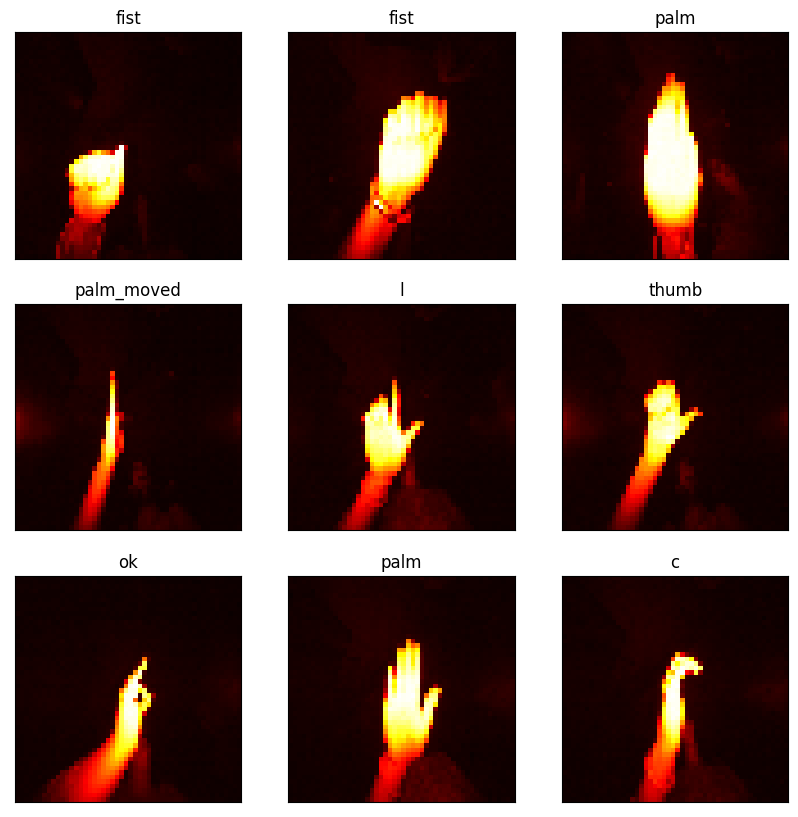

In [27]:
plt.figure(1, figsize=(10,10))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(image_data[i][0], cmap='hot')
    plt.xticks([])
    plt.yticks([])
    plt.title(CATEGORIES[label[i]][3:])
plt.show()

In [28]:
# Normalizing the data
input_data = np.array(input_data)
label = np.array(label)
input_data = input_data/255.0
input_data.shape

(20000, 50, 50)

In [29]:
# one hot encoding
label = keras.utils.to_categorical(label, num_classes=10,dtype='i1')
label[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int8)

In [30]:
# reshaping the data
input_data.shape = (-1, IMG_SIZE, IMG_SIZE, 1)

In [31]:
# splitting the input_data to train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_data, label, test_size = 0.3, random_state=0)

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense

# IMG_SIZE = 32  # Replace with the actual image size

# Define the model architecture
model = keras.models.Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Activation('relu'))

model.add(Conv2D(filters=32, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))


model.compile(loss='categorical_crossentropy',
             optimizer = 'rmsprop',
             metrics = ['accuracy'])


In [45]:
# Compile the model with quantization-aware training
quantize_model = tf.keras.models.clone_model(model)
quantize_model.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['accuracy'])



quantize_model.summary()

# Train the model with quantization-aware training
quantize_history=quantize_model.fit(X_train, y_train,
                   batch_size=32,
                   epochs=4,
                   validation_data=(X_test, y_test))

# Convert the model to a quantized version
converter = tf.lite.TFLiteConverter.from_keras_model(quantize_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()
# Save the quantized model to a file
with open('model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                      

In [46]:
history=model.fit(X_train, y_train, epochs = 4, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/4
438/438 [==============================] - 68s 155ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0022 - val_accuracy: 0.9995
Epoch 2/4
438/438 [==============================] - 68s 156ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0024 - val_accuracy: 0.9997
Epoch 3/4
438/438 [==============================] - 68s 156ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy: 0.9997
Epoch 4/4
438/438 [==============================] - 68s 156ms/step - loss: 2.3982e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 0.9998


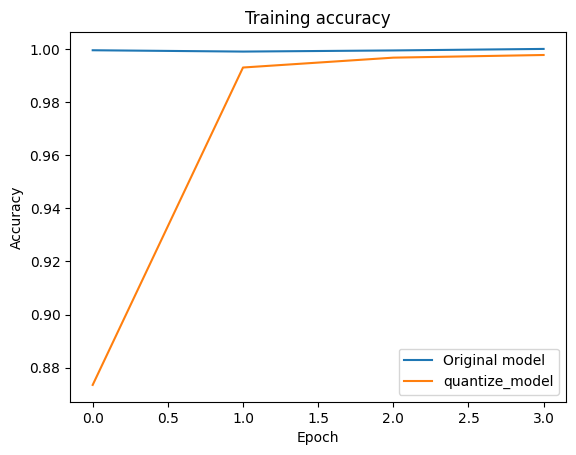

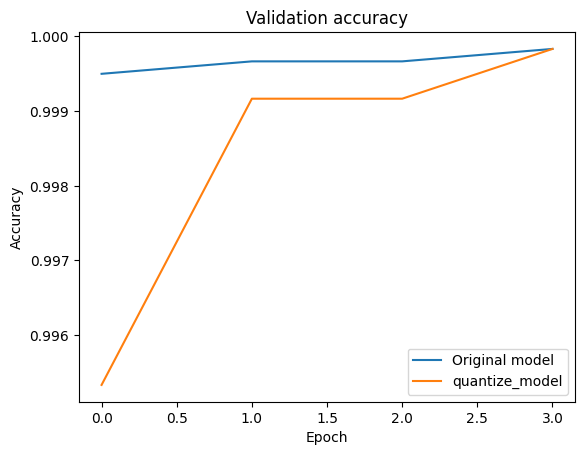

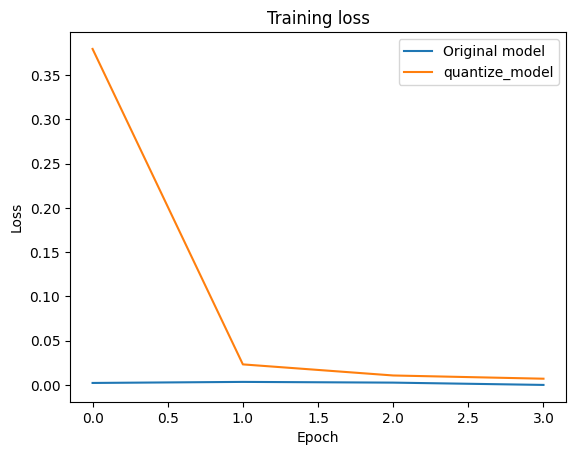

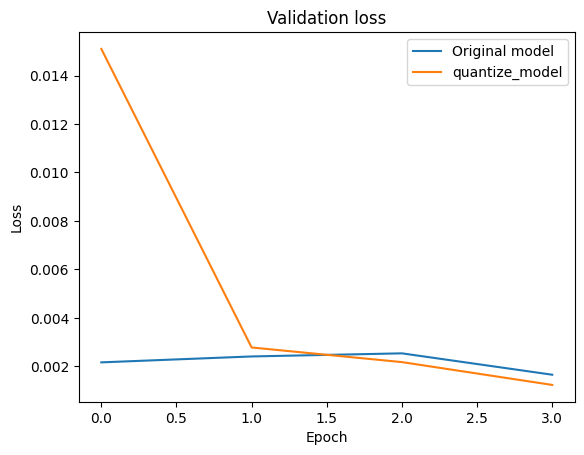

In [47]:
import matplotlib.pyplot as plt

# Plot the accuracy for the original model and the pruned model
plt.plot(history.history['accuracy'], label='Original model')
plt.plot(quantize_history.history['accuracy'], label='quantize_model')
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the validation accuracy for the original model and the pruned model
plt.plot(history.history['val_accuracy'], label='Original model')
plt.plot(quantize_history.history['val_accuracy'], label='quantize_model')
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the loss for the original model and the pruned model
plt.plot(history.history['loss'], label='Original model')
plt.plot(quantize_history.history['loss'], label='quantize_model')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the validation loss for the original model and the pruned model
plt.plot(history.history['val_loss'], label='Original model')
plt.plot(quantize_history.history['val_loss'], label='quantize_model')
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [48]:
quantize_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                      

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_6 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                      